<a href="https://colab.research.google.com/github/TithiB-del/Collaboratory-notebooks/blob/main/KerasCV_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

KerasCV makes it very easy to create simple model pipelines at a very fast rate. In this guide we create a simple image classification pipeline from scratch including augmentation, model building etc.

## Imports & setup

This tutorial requires you to have KerasCV installed:

```shell
pip install keras-cv
```

We begin by importing all required packages:

In [ ]:
!pip install keras_cv

In [ ]:
import numpy as np
import skimage.io as io
import random
import os
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

## Data loading

This guide uses the
[Cassava Leaf Disease Dataset](https://www.kaggle.com/competitions/cassava-leaf-disease-classification)
for demonstration purposes.

To get started, we first load the dataset:


In [ ]:
!wget https://storage.googleapis.com/kerascvnlp_data/cassava-leaf-disease-classification.zip

--2023-07-06 10:03:52--  https://storage.googleapis.com/kerascvnlp_data/cassava-leaf-disease-classification.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6185662420 (5.8G) [application/zip]
Saving to: ‘cassava-leaf-disease-classification.zip’

cassava-leaf-diseas 100%[===================>]   5.76G  18.9MB/s    in 5m 7s   

2023-07-06 10:09:00 (19.2 MB/s) - ‘cassava-leaf-disease-classification.zip’ saved [6185662420/6185662420]



In [ ]:
!unzip -qq /content/cassava-leaf-disease-classification.zip

In [ ]:
df = pd.read_csv('train.csv')
df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [ ]:
import shutil
target_folder = "dataset"
path = "train_images"

if not os.path.exists(target_folder):
    os.mkdir(target_folder)

for label in df['label'].unique():
    label_folder = os.path.join(target_folder, str(label))
    if not os.path.exists(label_folder):
        os.mkdir(label_folder)

    mask = df['label'] == label
    rows = df.loc[mask]

    for _, row in rows.iterrows():
        image_name = row['image_id']
        src_path = os.path.join(path, image_name)
        dst_path = os.path.join(label_folder, image_name)
        shutil.copy(src_path, dst_path)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
        '/content/dataset',
        labels="inferred",
        label_mode="categorical",
        class_names=None,
        color_mode="rgb",
        batch_size=16,
        image_size=(224,224),
        shuffle=True,
        seed=4,
        validation_split=0.1,
        subset="training",
        interpolation="bilinear",
        crop_to_aspect_ratio=False
    )

valid_dataset = tf.keras.utils.image_dataset_from_directory(
            '/content/dataset',
            labels="inferred",
            label_mode="categorical",
            class_names=None,
            color_mode="rgb",
            batch_size=16,
            image_size=(224,224),
            shuffle=True,
            seed=4,
            validation_split=0.1,
            subset="validation",
            interpolation="bilinear",
            crop_to_aspect_ratio=False
        )

Found 21397 files belonging to 5 classes.
Using 19258 files for training.
Found 21397 files belonging to 5 classes.
Using 2139 files for validation.


In [ ]:
def package_inputs(image, label):
    return {"images": image, "labels": label}

train_dataset = train_dataset.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = valid_dataset.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

## Data Augmentation

We use the various data augmentation layers from the KerasNLP like `RandomFlip`, `RandomCropAndResize` and `RandAugment`. We apply these augmentations to the dataset and then create the data generator for training the model.

In [ ]:
NUM_CLASSES = 5
IMAGE_SIZE=(224,224)
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]
crop_and_resize = keras_cv.layers.RandomCropAndResize(
    target_size=IMAGE_SIZE,
    crop_area_factor=(0.8, 1.0),
    aspect_ratio_factor=(0.9, 1.1),
)
augmenters += [crop_and_resize]
rand_augment = keras_cv.layers.RandAugment(
    augmentations_per_image=3,
    magnitude=0.3,
    value_range=(0, 255),
)
augmenters += [rand_augment]
augmenter = keras.Sequential(augmenters)
train_ds = train_dataset.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

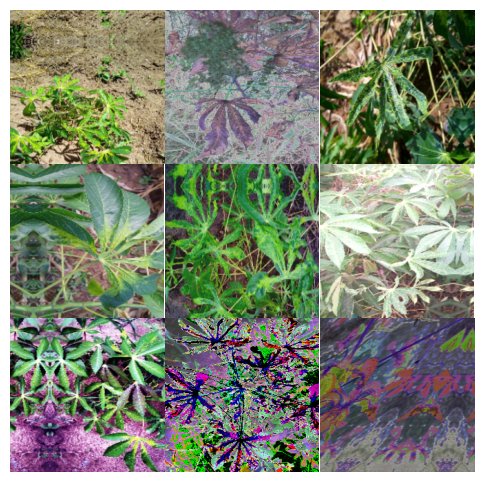

In [ ]:
image_batch = next(iter(train_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [ ]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = val_dataset.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

## Model Building

We start with creating a warmup cosine decay callback for learning rate scheduling of the classifier. After that we create a simple image classification model using the `ResNet18 V2` backbone and train it on the loaded dataset.

In [ ]:
from keras import losses
import numpy as np
from keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras import metrics
import math
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + tf.cos(
                tf.constant(math.pi)
                * tf.cast(global_step - warmup_steps - hold, tf.float32)
                / float(total_steps - warmup_steps - hold)
            )
        )
    )

    warmup_lr = tf.cast(target_lr * (global_step / warmup_steps), tf.float32)
    target_lr = tf.cast(target_lr, tf.float32)

    if hold > 0:
        learning_rate = tf.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return tf.where(step > self.total_steps, 0.0, lr, name="learning_rate")

In [ ]:
total_images = 19258
EPOCHS = 5
BATCH_SIZE=16
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)
optimizer = optimizers.SGD(
    decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

In [ ]:
backbone = keras_cv.models.ResNet18V2Backbone()
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(5, activation="softmax"),
    ]
)

In [ ]:
loss = losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[
        metrics.CategoricalAccuracy(),
        metrics.TopKCategoricalAccuracy(k=5),
    ],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_v2_backbone (ResNet  (None, None, None, 512)  11183488  
 V2Backbone)                                                     
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 11,186,053
Trainable params: 11,178,245
Non-trainable params: 7,808
_________________________________________________________________


In [ ]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=eval_ds,
)

Epoch 1/5
1204/1204 [==============================] - 405s 326ms/step - loss: 2.6275 - categorical_accuracy: 0.5529 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.5258 - val_categorical_accuracy: 0.6082 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/5
1204/1204 [==============================] - 384s 318ms/step - loss: 1.3822 - categorical_accuracy: 0.5980 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.2952 - val_categorical_accuracy: 0.5905 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/5
1204/1204 [==============================] - 381s 316ms/step - loss: 1.2759 - categorical_accuracy: 0.6076 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.2470 - val_categorical_accuracy: 0.5951 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/5
1204/1204 [==============================] - 380s 315ms/step - loss: 1.2331 - categorical_accuracy: 0.6129 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.2046 - val_categorical_accuracy: 0.6134 - val_top_k_categorical_accuracy: 1.0000
Epoc

In [ ]:
tt = train_ds.take(1)
image_batch,labels_batch = tuple(zip(*tt))

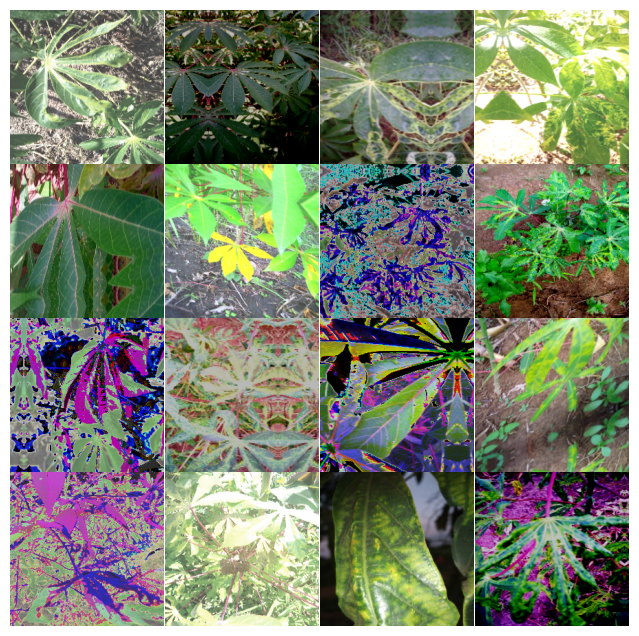

In [ ]:
keras_cv.visualization.plot_image_gallery(
    image_batch[0],
    rows=4,
    cols=4,
    value_range=(0, 255),
    show=True,
)

In [ ]:
pred = model.predict(image_batch[0])
print(np.argmax(pred,1))

1/1 [==============================] - 0s 400ms/step
[3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3]


In [ ]:
print(np.argmax(labels_batch[0],1))

[3 4 3 3 2 4 3 3 4 3 4 1 3 3 3 3]
